# 1.Simple_fcn

In [1]:
#  datasets dir
voc_root="./VOCdevkit/VOC2012/"
print(voc_root)

./VOCdevkit/VOC2012/


In [2]:
def read_images(root=voc_root,train=True):
    txt_filename=root+"/ImageSets/Segmentation/"+('train.txt'if train else 'val.txt')
    with open(txt_filename,'r') as f:
        images=f.read().split()
    data=[os.path.join(root,'JPEGImages',i+'.jpg')for i in images]
    label=[os.path.join(root,'SegmentationClass',i+'.png')for i in images]
    return data,label

In [3]:
import os
data,label=read_images()
# print(data,label)

In [4]:
import random
from torchvision.transforms import transforms as tfs
def rand_crop(data,label,height,width):
    h,w,_=data.shape
    top=random.randint(0,h-height)
    left=random.randint(0,w-width)
    data=data[top:top+height,left:left+width]
    label=label[top:top+height,left:left+width]
    return data,label

In [5]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [6]:
import numpy as np
cm2lbl=np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]]=i

def image2label(im):
    data=np.array(im,dtype='int32')
    idx=(data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return np.array(cm2lbl[idx],dtype='int64')

In [7]:
from PIL import Image
label_im = Image.open('./VOCdevkit/VOC2012/SegmentationClass/2007_000033.png').convert('RGB')
label_im.show()
label = image2label(label_im)
label[150:160, 240:250]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [8]:
def img_transforms(im,label,crop_size):
    im,label=rand_crop(im,label,*crop_size)
    im_tfs=tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    im=im_tfs(im)
    label=image2label(label)
    label=torch.from_numpy(label)
    return im,label

In [9]:
from torch.utils.data import Dataset
import cv2
class VOCSegDataset(Dataset):
    def __init__(self,train,crop_size,transforms):
        self.crop_size=crop_size
        self.transforms=transforms
        data_list,label_list=read_images(train=train)
        self.data_list=self._filter(data_list)
        self.label_list=self._filter(label_list)
        print('Read'+str(len(self.data_list))+'images')
    def _filter(self,images):
        return [im for im in images if(Image.open(im).size[1] >= self.crop_size[0] and
                                      Image.open(im).size[0] >= self.crop_size[1])]
    def __getitem__(self,idx):
        img=self.data_list[idx]
        label=self.label_list[idx]
        img=cv2.imread(img)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label=cv2.imread(label)
        label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        img,label=self.transforms(img,label,self.crop_size)
        return img,label
    
    def __len__(self):
        return len(self.data_list)

In [10]:
input_shape=(320,480)
voc_train=VOCSegDataset(True,input_shape,img_transforms)
voc_test=VOCSegDataset(False,input_shape,img_transforms)

Read1114images
Read1078images


In [11]:
from torch.utils.data import DataLoader
train_data=DataLoader(voc_train,batch_size=6,shuffle=True)
valid_data=DataLoader(voc_test,batch_size=6)

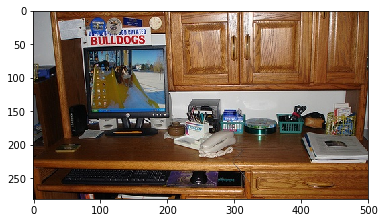

In [13]:
import torch
import  matplotlib.pyplot as plt
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor=(kernel_size+1)//2
    if kernel_size%2==1:
        center=factor-1
    else:
        center=factor-0.5
    og=np.ogrid[:kernel_size,:kernel_size]
    filt=(1-abs(og[0]-center)/factor)*(1-abs(og[1]-center)/factor)
    weight=np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype='float32')
    weight[range(in_channels),range(out_channels),:,:]=filt
    return torch.from_numpy(weight)

x=Image.open('./VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg')
x=np.array(x)
plt.imshow(x)
plt.show()
    

(562, 1000, 3)


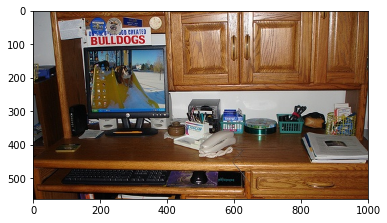

In [14]:
import  torch.nn as nn
from torch.autograd import Variable
x=torch.from_numpy(x.astype('float32')).permute(2,0,1).unsqueeze(0)
conv_trans=nn.ConvTranspose2d(3,3,4,2,1)
conv_trans.weight.data=bilinear_kernel(3,3,4)

y=conv_trans(Variable(x)).data.squeeze().permute(1,2,0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

In [34]:
from torchvision import models
pretrained_net=models.resnet34(pretrained=True)
num_classes=len(classes)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/smart/.torch/models/resnet34-333f7ec4.pth
87306240it [00:32, 2657967.04it/s]


In [35]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        
    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8
        
        x = self.stage2(x)
        s2 = x # 1/16
        
        x = self.stage3(x)
        s3 = x # 1/32
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s2)
        return s
    
        

In [36]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

In [37]:

criterion = nn.NLLLoss2d()

net=fcn(num_classes)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)


/home/smart/.local/lib/python3.5/site-packages/torch/nn/modules/loss.py:217: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [48]:
import time
import torch.nn.functional as F
for e in range(120):
    
    train_loss = 0
    train_acc = 0
    train_acc_cls = 0
    train_mean_iu = 0
    train_fwavacc = 0
    
    prev_time = time.time()
    net = net.train()
    net=net.cuda()
    for data in train_data:
        im = Variable(data[0].cuda())
        label = Variable(data[1].cuda())
#         print(label.shape)
        # forward
        out = net(im)
#         print(out.shape)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            train_acc += acc
            train_acc_cls += acc_cls
            train_mean_iu += mean_iu
            train_fwavacc += fwavacc
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_acc_cls = 0
    eval_mean_iu = 0
    eval_fwavacc = 0
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        label = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        eval_loss += loss.data
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            eval_acc += acc
            eval_acc_cls += acc_cls
            eval_mean_iu += mean_iu
            eval_fwavacc += fwavacc
        
    cur_time = time.time()

    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(voc_train), train_mean_iu / len(voc_train),
        eval_loss / len(valid_data), eval_acc / len(voc_test), eval_mean_iu / len(voc_test)))
   
    print(epoch_str)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 0, Train Loss: 0.10660, Train Acc: 0.96078, Train Mean IU: 0.77074, Valid Loss: 0.41901, Valid Acc: 0.88829, Valid Mean IU: 0.53813 
Epoch: 1, Train Loss: 0.10601, Train Acc: 0.96074, Train Mean IU: 0.77281, Valid Loss: 0.41855, Valid Acc: 0.88781, Valid Mean IU: 0.53831 
Epoch: 2, Train Loss: 0.10738, Train Acc: 0.96054, Train Mean IU: 0.77307, Valid Loss: 0.40613, Valid Acc: 0.89163, Valid Mean IU: 0.54537 
Epoch: 3, Train Loss: 0.11099, Train Acc: 0.95975, Train Mean IU: 0.76602, Valid Loss: 0.42157, Valid Acc: 0.88890, Valid Mean IU: 0.54506 
Epoch: 4, Train Loss: 0.10907, Train Acc: 0.95982, Train Mean IU: 0.76196, Valid Loss: 0.42308, Valid Acc: 0.88859, Valid Mean IU: 0.54246 
Epoch: 5, Train Loss: 0.10488, Train Acc: 0.96133, Train Mean IU: 0.77486, Valid Loss: 0.41495, Valid Acc: 0.88843, Valid Mean IU: 0.54178 
Epoch: 6, Train Loss: 0.10692, Train Acc: 0.96092, Train Mean IU: 0.77676, Valid Loss: 0.40619, Valid Acc: 0.88985, Valid Mean IU: 0.53280 
Epoch: 7, Train Loss

Epoch: 59, Train Loss: 0.08425, Train Acc: 0.96780, Train Mean IU: 0.81295, Valid Loss: 0.43663, Valid Acc: 0.89241, Valid Mean IU: 0.54305 
Epoch: 60, Train Loss: 0.08325, Train Acc: 0.96803, Train Mean IU: 0.81767, Valid Loss: 0.43624, Valid Acc: 0.89120, Valid Mean IU: 0.53911 
Epoch: 61, Train Loss: 0.08374, Train Acc: 0.96799, Train Mean IU: 0.81999, Valid Loss: 0.43969, Valid Acc: 0.89250, Valid Mean IU: 0.54837 
Epoch: 62, Train Loss: 0.08278, Train Acc: 0.96806, Train Mean IU: 0.81895, Valid Loss: 0.43182, Valid Acc: 0.89168, Valid Mean IU: 0.54705 
Epoch: 63, Train Loss: 0.08179, Train Acc: 0.96851, Train Mean IU: 0.82030, Valid Loss: 0.44734, Valid Acc: 0.89171, Valid Mean IU: 0.53937 
Epoch: 64, Train Loss: 0.08236, Train Acc: 0.96837, Train Mean IU: 0.82128, Valid Loss: 0.43813, Valid Acc: 0.89235, Valid Mean IU: 0.54496 
Epoch: 65, Train Loss: 0.08178, Train Acc: 0.96844, Train Mean IU: 0.82203, Valid Loss: 0.44487, Valid Acc: 0.89226, Valid Mean IU: 0.54838 
Epoch: 66, Tr

Epoch: 117, Train Loss: 0.07323, Train Acc: 0.97129, Train Mean IU: 0.83637, Valid Loss: 0.45918, Valid Acc: 0.89307, Valid Mean IU: 0.54761 
Epoch: 118, Train Loss: 0.07372, Train Acc: 0.97112, Train Mean IU: 0.83909, Valid Loss: 0.45100, Valid Acc: 0.89203, Valid Mean IU: 0.54586 
Epoch: 119, Train Loss: 0.07437, Train Acc: 0.97099, Train Mean IU: 0.83507, Valid Loss: 0.46383, Valid Acc: 0.89073, Valid Mean IU: 0.53931 


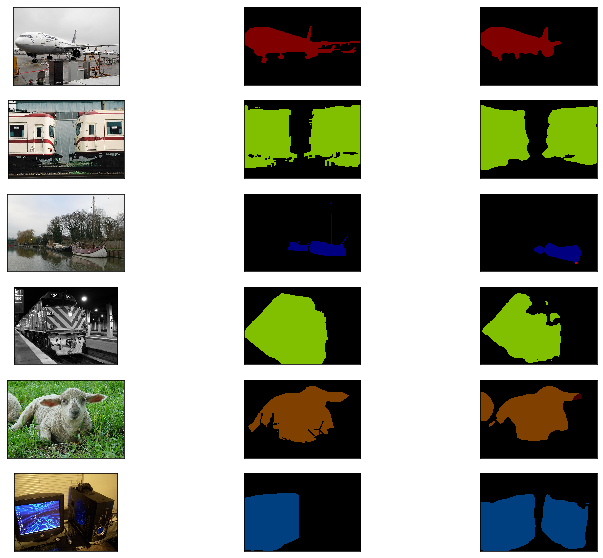

In [49]:
# 定义预测函数
cm = np.array(colormap).astype('uint8')

def predict(im, label): # 预测结果
    im = Variable(im.unsqueeze(0)).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]


_, figs = plt.subplots(6, 3, figsize=(12, 10))
for i in range(16):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)

In [50]:
torch.save(net.state_dict(),'fcn_resnet34.pth')

In [55]:
net=fcn(num_classes)

In [59]:
net.load_state_dict(torch.load('./fcn_resnet34.pth'))
net=net.cuda()

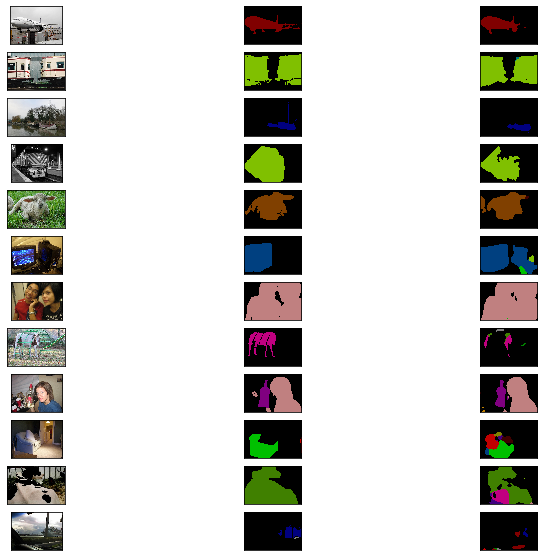

In [62]:
# 定义预测函数
cm = np.array(colormap).astype('uint8')

def predict(im, label): # 预测结果
    im = Variable(im.unsqueeze(0)).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]


_, figs = plt.subplots(12, 3, figsize=(12, 10))
for i in range(12):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)